In [1]:
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm
import IPython.display as display
import copy
import seaborn as sns

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_31555/1895528008.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shou

In [2]:
def merge_csv_files(directory):
    # Get a list of all the csv files
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Initialize an empty list to hold dataframes
    dfs = []

    # Loop through csv files, read each into a dataframe, and append to the list
    for file in csv_files:
        # Extract date from filename, assuming the date is in format 'traffic_flow_YYYY_MM_DD'
        date_str = file.split('.')[0].split('_')[-3:]  # This gives ['YYYY', 'MM', 'DD']
        date = datetime.strptime('_'.join(date_str), '%Y_%m_%d').date()

        df = pd.read_csv(os.path.join(directory, file))

        # Add date as a new column
        df['date'] = date.strftime('%m/%d/%y')

        dfs.append(df)

    # Concatenate all dataframes in the list into one dataframe
    merged_df = pd.concat(dfs, ignore_index=True).drop_duplicates()

    # Return the merged dataframe
    return merged_df

In [3]:
traffic_flows = merge_csv_files(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()
traffic_flows['total'] = traffic_flows['bus'] + traffic_flows['car'] + traffic_flows['cycle'] + traffic_flows['walks'] + \
                         traffic_flows['stationary']

In [4]:
lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'

inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
# tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
# tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

# tube_station = gpd.read_file(tube_station)
# tube_station.to_crs(epsg=27700, inplace=True)
# tube_station = gpd.sjoin(tube_station, inoutter, op='within')

# tube_line = gpd.read_file(tube_line)
# tube_line.to_crs(epsg=27700, inplace=True)
# tube_line = gpd.sjoin(tube_line, inoutter, op='within')

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})
road_network.rename(columns={'NAME': 'boroughs'}, inplace=True)
road_network.loc[:, ['cycle_lane', 'bus_lane']] = road_network[['cycle_lane', 'bus_lane']].fillna('n')

In [5]:
flows = pd.merge(
    road_network[
        ['toid', 'roadclassi', 'geometry', 'cycle_lane', 'bus_lane', 'boroughs']],
    traffic_flows, left_on='toid', right_on='toid', how='left')
flows.set_geometry('geometry', inplace=True)

flows['classification'] = flows['roadclassi'].replace(
    {'Unknown': 'Local Road', 'Not Classified': 'Local Road', 'Unclassified': 'Local Road',
     'Classified Unnumbered': 'Local Road', 'A Road': 'Strategic Road', 'B Road': 'Strategic Road'})

flows.drop(columns=['roadclassi'], inplace=True)

stage_date = ['03/01/22', '02/22/22', '03/08/22']
flows = flows.loc[flows['date'].isin(stage_date)]

# label the regional level
flows = gpd.sjoin(flows, inoutter, how='inner', predicate='within')
flows = flows.drop(columns=['index_right', 'Source', 'Area_Ha', 'Shape_Leng', 'Shape_Area'])
flows.reset_index(drop=True, inplace=True)

merged = flows
flows = merged

# convert the dataframe
flows = pd.melt(flows,
                id_vars=['toid', 'classification', 'geometry', 'date', 'Boundary', 'cycle_lane', 'bus_lane',
                         'boroughs'],
                var_name='mode', value_name='flow')

flows = pd.pivot_table(flows,
                       index=['toid', 'classification', 'geometry', 'Boundary', 'mode', 'cycle_lane', 'bus_lane',
                              'boroughs'],
                       columns='date',
                       values='flow',
                       aggfunc='first').reset_index()

flows = flows.groupby(
    ['toid', 'mode', 'classification', 'geometry', 'Boundary', 'cycle_lane', 'bus_lane', 'boroughs'],
    as_index=False).agg(
    {'03/01/22': 'first', '02/22/22': 'first', '03/08/22': 'first'})
# Calculate the impact and recovery flows for one strike
flows['impact_flow'] = flows['03/01/22'] - flows['02/22/22']
flows['recovery_flow'] = flows['03/08/22'] - flows['03/01/22']

# Calculate impact rate while avoiding division by zero
flows['impact_rate'] = flows.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
flows['recovery_rate'] = flows.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

In [6]:
speed = merge_csv_files(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/Traffic flow with speed')
speed = speed.groupby(['travel_mode', 'toid', 'date']).agg({'speed_overall': 'mean'}).reset_index()
speed = speed.pivot(index=['toid', 'travel_mode'], columns='date', values='speed_overall').reset_index()
speed.rename(columns={'03/01/22': 'speed_03/01/22', '02/22/22': 'speed_02/22/22', '03/08/22': 'speed_03/08/22'},
             inplace=True)
columns_to_sum = ['speed_03/01/22', 'speed_02/22/22', 'speed_03/08/22']
toid_mode_totals = speed.groupby(['toid', 'travel_mode'])[columns_to_sum].sum().reset_index()

# 创建一个包含 'total' 行的 DataFrame
total_row = toid_mode_totals.groupby('toid')[columns_to_sum].sum().reset_index()
total_row['travel_mode'] = 'total'

speed = pd.concat([toid_mode_totals, total_row], ignore_index=True)

# Calculate the impact and recovery flows for one strike
speed['impact_speed'] = speed['speed_03/01/22'] - speed['speed_02/22/22']
speed['recovery_speed'] = speed['speed_03/08/22'] - speed['speed_03/01/22']

speed['impact_speed_rate'] = speed.apply(
    lambda row: round(row['impact_speed'] / row['speed_02/22/22'], 4) if row['speed_02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
speed['recovery_speed_rate'] = speed.apply(
    lambda row: round(row['recovery_speed'] / row['speed_03/01/22'], 4) if row['speed_03/01/22'] != 0 else 0, axis=1)
flows = pd.merge(flows, speed, left_on=['toid', 'mode'], right_on=['toid', 'travel_mode'], how='left')
flows.drop(columns=['travel_mode'], inplace=True)
flows

date,toid,mode,classification,geometry,Boundary,cycle_lane,bus_lane,boroughs,03/01/22,02/22/22,...,recovery_flow,impact_rate,recovery_rate,speed_03/01/22,speed_02/22/22,speed_03/08/22,impact_speed,recovery_speed,impact_speed_rate,recovery_speed_rate
0,osgb4000000027865921,bus,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,16,11,...,-4,0.4545,-0.2500,1.866527,1.691628,1.966679,0.174899,0.100152,0.1034,0.0537
1,osgb4000000027865921,car,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,1041,1100,...,40,-0.0536,0.0384,1.699271,1.998224,1.852627,-0.298953,0.153356,-0.1496,0.0902
2,osgb4000000027865921,cycle,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,14,4,...,-7,2.5000,-0.5000,1.884427,1.883744,1.727556,0.000683,-0.156872,0.0004,-0.0832
3,osgb4000000027865921,stationary,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,2,0,...,-1,0.0000,-0.5000,1.004754,0.000000,0.000000,1.004754,-1.004754,0.0000,-1.0000
4,osgb4000000027865921,total,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,1095,1151,...,27,-0.0487,0.0247,6.721938,5.940743,6.116473,0.781195,-0.605465,0.1315,-0.0901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729087,osgb5000005242182149,car,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,33,54,...,18,-0.3889,0.5455,0.354515,0.357080,0.343335,-0.002565,-0.011180,-0.0072,-0.0315
1729088,osgb5000005242182149,cycle,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,2,1,...,-1,1.0000,-0.5000,0.000000,0.264922,0.585180,-0.264922,0.585180,-1.0000,0.0000
1729089,osgb5000005242182149,stationary,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,3,4,...,2,-0.2500,0.6667,0.000107,0.000151,0.000061,-0.000044,-0.000046,-0.2902,-0.4319
1729090,osgb5000005242182149,total,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,50,74,...,20,-0.3243,0.4000,0.773392,0.661585,1.025616,0.111807,0.252224,0.1690,0.3261


In [7]:
All = flows.copy()

## Graph

In [ ]:
selected_mode = 'stationary'
flows = All[All['mode'] == selected_mode]
flows.reset_index(drop=True)

In [ ]:
# creat a blank graph
graph = nx.Graph()

# iterate over the rows of the flows DataFrame
for _, row in flows.iterrows():
    mode = row['mode']
    geometry = row['geometry']
    baseline_1 = row['02/22/22']
    strike_1 = row['03/01/22']
    recovery_1 = row['03/08/22']
    impact_flow = row['impact_flow']
    recovery_flow = row['recovery_flow']
    impact_rate = row['impact_rate']
    recovery_rate = row['recovery_rate']
    impact_speed = row['impact_speed']
    recovery_speed = row['recovery_speed']
    impact_speed_rate = row['impact_speed_rate']
    recovery_speed_rate = row['recovery_speed_rate']

    # break the MultiLineString geometry into its constituent LineStrings
    if geometry.geom_type == 'MultiLineString':
        for line_string in geometry.geoms:  # iterate over each LineString
            from_node = line_string.coords[0]
            to_node = line_string.coords[-1]

            # Add nodes to the graph
            graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
            graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
            # Add edges to the graph based on the direction

            graph.add_edge(to_node, from_node, baseline_1=baseline_1, strike_1=strike_1,
                           recovery_1=recovery_1, impact_flow=impact_flow, recovery_flow=recovery_flow,
                           impact_rate=impact_rate, recovery_rate=recovery_rate, impact_speed_rate=impact_speed_rate,
                           recovery_speed_rate=recovery_speed_rate, impact_speed=impact_speed,
                           recovery_speed=recovery_speed, mode=mode,
                           toid=row['toid'], classification=row['classification'], geometry=row['geometry'])

            '''if direction == 'bothDirections':
                # If the road is bidirectional, flows are split equally in both directions
                graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                               recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
                graph.add_edge(to_node,
                               from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2, recovery_1=recovery_1 / 2,
                               impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
            elif direction == 'inOppositeDirection':
            # If the road is in the opposite direction, flows are from the ending point to the starting point

            elif direction == 'inDirection':
                # If the road is in the same direction, flows are from the starting point to the ending point
                graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                               recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])'''

    else:
        from_node = geometry.coords[0]
        to_node = geometry.coords[-1]

        # Add nodes to the graph
        graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
        graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
        # Add edges to the graph based on the direction

        graph.add_edge(to_node, from_node, baseline_1=baseline_1, strike_1=strike_1, recovery_1=recovery_1,
                       impact_flow=impact_flow, recovery_flow=recovery_flow, toid=row['toid'], impact_rate=impact_rate,
                       recovery_rate=recovery_rate, impact_speed_rate=impact_speed_rate,
                       recovery_speed_rate=recovery_speed_rate, impact_speed=impact_speed,
                       recovery_speed=recovery_speed, mode=mode,
                       classification=row['classification'], geometry=row['geometry'])

    ''' 
     if direction == 'bothDirections':
         # If the road is bidirectional, flows are split equally in both directions
         graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                        recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                        toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
         graph.add_edge(to_node, from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                        recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                        toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
     elif direction == 'inOppositeDirection':
         # If the road is in the opposite direction, flows are from the ending point to the starting point
         graph.add_edge(to_node, from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                        recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                        toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
     elif direction == 'inDirection':
         # If the road is in the same direction, flows are from the starting point to the ending point
         graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                        recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                        toid=row['toid'], classification=row['classification'], geometry=row['geometry'])'''


In [ ]:
connected_components = list(nx.connected_components(graph))
largest_component = max(connected_components, key=len)
edges_list = list(graph.edges())

# make sure the graph is not empty
if edges_list:
    # obtain the start and end coordinates of the first edge
    u, v = edges_list[0]

    # obtain the edge attribute of the first edge
    edge_attr = graph[u][v]

    print(f"The first edge: ({u}, {v})")
    print("Attribute: ", edge_attr)

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# 
# def graph_visualization(graph, weight=None, cmap='Greens'):
#     # obtain all the edges in the graph
#     edges_list = list(graph.edges())
# 
#     # make sure the graph is not empty
#     if edges_list:
#         # obtain the start and end coordinates of the first edge
#         u, v = edges_list[0]
# 
#         # obtain the edge attribute of the first edge
#         edge_attr = graph[u][v]
# 
#         print(f"The first edge: ({u}, {v})")
#         print("Attribute: ", edge_attr)
#     else:
#         print("No edge in the graph.")
# 
#     # get the node positions
#     node_positions = nx.get_node_attributes(graph, 'pos')
# 
#     # get the edge weights
#     edge_weight = nx.get_edge_attributes(graph, weight)
# 
#     # normalize the edge weights between 0 and 1
#     weight_values = list(edge_weight.values())
#     norm = Normalize(vmin=min(weight_values), vmax=max(weight_values))
#     norm_weight = {edge: norm(weight) for edge, weight in edge_weight.items()}
# 
#     # create a colormap
#     cmap_object = plt.get_cmap(cmap)
#     mappable = ScalarMappable(norm=norm, cmap=cmap_object)
#     mappable.set_array([])
# 
#     # plot the graph
#     fig, ax = plt.subplots()
#     nx.draw_networkx_edges(graph, pos=node_positions, edge_color='gray')
#     nx.draw_networkx_edges(graph, pos=node_positions,
#                            edge_color=[mappable.to_rgba(norm_weight[edge]) for edge in edges_list])
# 
#     # add a colorbar
#     cbar = plt.colorbar(mappable, ax=ax, orientation='horizontal', pad=0.01)
#     cbar.set_label(weight)
# 
#     plt.title(f'Graph Representation of the Road Network', size=10)
#     plt.axis('off')
#     plt.show()

In [ ]:
# graph_visualization(graph, weight='impact_flow')
# graph_visualization(graph, weight='recovery_flow')

#### Calculate the structure-based indicators for roads and system


In [ ]:
# calculate the number of nodes
nodes_number = graph.number_of_nodes()

# calculate the number of edges
links_number = graph.number_of_edges()

# calculate the total link weight
total_link_weight = sum([data['impact_flow'] for u, v, data in graph.edges(data=True)])

mean_link_weight = total_link_weight / links_number

# calculate the coefficient of variation of node degree
node_degrees = dict(graph.degree())
mean_node_degree = np.mean(list(node_degrees.values()))
std_node_degree = np.std(list(node_degrees.values()))
node_degree_cv = (std_node_degree / mean_node_degree) * 100

# calculate the coefficient of variation of edge weight
edge_weights = nx.get_edge_attributes(graph, 'impact_rate').values()
mean_edge_weight = np.mean(list(edge_weights))
std_edge_weight = np.std(list(edge_weights))
edge_weight_cv = (std_edge_weight / mean_edge_weight) * 100

# calculate the network connectivity and score for graph
network_connectivity = nx.is_connected(graph)
connectivity_score = 2 * links_number / (nodes_number * nodes_number)
# calculate the average clustering coefficient for graph
avg_clustering_coefficient = nx.average_clustering(graph)
# calculate the transitivity for graph
transitivity = nx.transitivity(graph)
# calculate the assortativity for graph
assortativity = nx.degree_assortativity_coefficient(graph)
# calculate indicators as attributes for each road
clustering_coefficients = nx.clustering(graph)
# eigenvector_centrality = nx.eigenvector_centrality(graph)
# calculate the node degrees
node_degrees = graph.degree()

# calculate the average degree for graph
average_degree = sum(dict(node_degrees).values()) / len(node_degrees)

In [ ]:
for u, v in graph.edges():
    edge_clustering_coefficient = (clustering_coefficients[u] + clustering_coefficients[v]) / 2
    graph[u][v]['clustering_coefficient'] = edge_clustering_coefficient
    graph[u][v]['degree'] = (node_degrees[u] + node_degrees[v]) / 2

In [ ]:
import igraph as ig
import networkx as nx

# Create a mapping from networkx nodes to consecutive integers
node_to_index = {node: idx for idx, node in enumerate(graph.nodes())}

# Convert networkx graph to igraph using edge list with mapped indices
tuples = [(node_to_index[u], node_to_index[v]) for u, v in graph.edges()]
ig_graph = ig.Graph.TupleList(tuples, directed=False)

# Create a reverse mapping from igraph indices to networkx node identifiers
index_to_node = {idx: node for node, idx in node_to_index.items()}

# Calculate edge betweenness centrality using igraph
edge_betweenness = ig_graph.edge_betweenness(directed=False, weights=None)

# Ensure the order of edges in igraph matches the order in networkx
ig_edges = [(index_to_node[edge.source], index_to_node[edge.target]) for edge in ig_graph.es]

# Map betweenness values back to networkx edges
for (u, v), betw in zip(ig_edges, edge_betweenness):
    if (u, v) in graph.edges():
        graph[u][v]['betweenness'] = betw
    elif (v, u) in graph.edges():  # Handle undirected case
        graph[v][u]['betweenness'] = betw


In [ ]:
edges_list = list(graph.edges())

# make sure the graph is not empty
if edges_list:
    # obtain the start and end coordinates of the first edge
    u, v = edges_list[0]

    # obtain the edge attribute of the first edge
    edge_attr = graph[u][v]

    print(f"The first edge: ({u}, {v})")
    print("Attribute: ", edge_attr)

In [ ]:
# Print the calculated indicators
print("Total Nodes Number:", nodes_number)
print("Total Links Number:", links_number)
print("Total Flows:", round(total_link_weight))
print("Mean Link Flow:", mean_link_weight)
print("Node Degree Coefficient of Variation:", node_degree_cv)
print("Edge Weight Coefficient of Variation:", edge_weight_cv)
print("Connectivity Score:", connectivity_score)
print("Network Connectivity:", network_connectivity)
print("Transitivity:", transitivity)
print("Assortativity:", assortativity)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Average Degree:", average_degree)
print('Average Betweenness Centrality:', sum(nx.get_edge_attributes(graph, 'betweenness').values()) / len(
    nx.get_edge_attributes(graph, 'betweenness').values()))

In [ ]:
print(len(edge_betweenness))
print(len(nx.get_edge_attributes(graph, 'toid').values()))

mid_record = pd.DataFrame({'toid': nx.get_edge_attributes(graph, 'toid').values(),
                           'betweenness': edge_betweenness,
                           'clustering_coefficient': nx.get_edge_attributes(graph, 'clustering_coefficient').values(),
                           'degree': nx.get_edge_attributes(graph, 'degree').values()
                           })



In [ ]:
# graph_visualization(graph, weight='betweenness')
# graph_visualization(graph, weight='clustering_coefficient')
# graph_visualization(graph, weight='eigenvector_centrality')

### Network DBSCAN Clustering

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# 
# # 将边的权重属性值作为数据点
# edges_list = list(graph.edges())
# data_points = np.array([graph[u][v]['impact_flow'] for u, v in edges_list]).reshape(-1, 1)
# # 创建模型
# dbscan = DBSCAN()
# 
# # 定义要搜索的参数范围
# param_grid = {'eps': [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples': [1, 2, 3, 4, 5, 6]}
# 
# best_score = -1
# best_eps = None
# best_min_samples = None
# 
# # 在数据上执行交叉验证
# for eps in param_grid['eps']:
#     for min_samples in param_grid['min_samples']:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(data_points)
#         if len(set(labels)) > 1:  # 忽略只有一个簇的情况
#             score = silhouette_score(data_points, labels)
#             if score > best_score:
#                 best_score = score
#                 best_eps = eps
#                 best_min_samples = min_samples
# 
# print("Best EPS:", best_eps)
# print("Best Min Samples:", best_min_samples)
# 
# # 使用最佳参数进行DBSCAN聚类
# best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
# best_labels = best_dbscan.fit_predict(data_points)
# 
# # 将聚类结果应用于图
# for i, (u, v) in enumerate(edges_list):
#     graph[u][v]['cluster_DB'] = best_labels[i]
# 
# # 打印聚类的唯一值
# unique_clusters = set(best_labels)
# print("Unique Cluster Values:", unique_clusters)
# 


In [ ]:
# # 创建颜色映射
# cmap = plt.get_cmap('tab20', len(unique_clusters))
# 
# # 绘制图形
# fig, ax = plt.subplots()
# pos_cluster = nx.fruchterman_reingold_layout(graph)
# 
# for u, v, attr in graph.edges(data=True):
#     cluster = attr['cluster_DB']
#     if cluster == -1:
#         edge_color = 'lightgrey'  # 将 -1 标签的边设置为浅灰色
#     else:
#         edge_color = cmap(cluster)
#     nx.draw_networkx_edges(graph, pos_cluster, edgelist=[(u, v)], width=1, edge_color=edge_color)
# 
# # 创建不连续的分类点图例
# unique_labels = np.unique(best_labels)
# handles = []
# for label in unique_labels:
#     if label == -1:  # 处理 -1 标签
#         handle = plt.Line2D([], [], color='lightgrey', marker='o', markersize=10, label='Noise')
#     else:
#         color = cmap(label)
#         handle = plt.Line2D([], [], color=color, marker='o', markersize=10, label=f'Cluster {label}')
#     handles.append(handle)
# 
# # 添加图例
# ax.legend(handles=handles, title='Clusters', loc='upper left', bbox_to_anchor=(1, 1))
# 
# plt.axis('off')
# plt.title("DBSCAN Clustering of Graph Edges")
# plt.show()
# 
# node_positions = nx.get_node_attributes(graph, 'pos')
# nx.draw_networkx_edges(graph, node_positions, width=1, edge_color=cmap(best_labels))
# plt.title("DBSCAN Clustering in network")
# plt.axis('off')
# plt.show()


### Network K-Means Clustering


#### By Degree

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 
# # 从图中获取节点的度作为特征
# node_features = np.array([graph.degree(node) for node in graph.nodes()]).reshape(-1, 1)
# # 使用 Z-Score 标准化对节点特征进行归一化
# scaler = StandardScaler()
# normalized_features = scaler.fit_transform(node_features)
# 
# # 使用 Min-Max 缩放对节点特征进行归一化到 [0, 1] 范围
# minmax_scaler = MinMaxScaler()
# node_features = minmax_scaler.fit_transform(node_features)
# 
# # 使用K均值算法进行聚类
# k = 7  # 聚类数量
# kmeans = KMeans(n_clusters=k)
# cluster_labels = kmeans.fit_predict(node_features)
# 
# # 将聚类结果应用于图
# for i, node in enumerate(graph.nodes()):
#     graph.nodes[node]['cluster_k'] = cluster_labels[i]
# 
# # 初始化节点的累计flow和度的字典
# node_weight = {node: 0 for node in graph.nodes()}
# node_degrees = {node: 0 for node in graph.nodes()}
# 
# # 遍历边，累计flow和度
# for u, v, attr in graph.edges(data=True):
#     weight = attr['impact_rate']
#     node_weight[u] += weight
#     node_weight[v] += weight
#     node_degrees[u] += 1
#     node_degrees[v] += 1
# 
# # 计算每个节点的特征（平均flow）
# node_features = np.array(
#     [node_weight[node] / node_degrees[node] if node_degrees[node] > 0 else 0 for node in graph.nodes()]).reshape(-1, 1)
# 
# # 创建颜色映射
# cmap = plt.get_cmap('tab20', k)
# 
# # 绘制图形
# fig, ax = plt.subplots()
# pos = nx.fruchterman_reingold_layout(graph)
# 
# for u, v, attr in graph.edges(data=True):
#     u_cluster = graph.nodes[u]['cluster_k']
#     v_cluster = graph.nodes[v]['cluster_k']
# 
#     if u_cluster == v_cluster:
#         cluster = u_cluster
#     else:
#         cluster = -1  # 表示不同的聚类
#     if cluster == -1:
#         edge_color = 'lightgrey'  # 将不同聚类的边设置为浅灰色
#     else:
#         edge_color = cmap(cluster)
#     nx.draw_networkx_edges(graph, pos_cluster, edgelist=[(u, v)], width=1, edge_color=edge_color)
# 
# # 创建不连续的分类点图例
# unique_labels = np.unique(cluster_labels)
# handles = []
# for label in unique_labels:
#     if label == -1:  # 处理 -1 标签
#         handle = plt.Line2D([], [], color='lightgrey', marker='o', markersize=10, label='Noise')
#     else:
#         color = cmap(label)
#         handle = plt.Line2D([], [], color=color, marker='o', markersize=10, label=f'Cluster {label}')
#     handles.append(handle)
# 
# # 添加图例
# ax.legend(handles=handles, title='Clusters', loc='upper left', bbox_to_anchor=(1, 1)).set_draggable(True)
# 
# plt.axis('off')
# plt.title("KMeans Clustering of Graph Nodes")
# plt.show()
# 
# # Plot the clusters in the network
# node_positions = nx.get_node_attributes(graph, 'pos')
# nx.draw_networkx_edges(graph, node_positions, width=1, edge_color=cmap(cluster_labels))
# # 创建不连续的分类点图例
# unique_labels = np.unique(cluster_labels)
# handles = []
# for label in unique_labels:
#     if label == -1:  # 处理 -1 标签
#         handle = plt.Line2D([], [], color='lightgrey', marker='o', markersize=10, label='Noise')
#     else:
#         color = cmap(label)
#         handle = plt.Line2D([], [], color=color, marker='o', markersize=10, label=f'Cluster {label}')
#     handles.append(handle)
# 
# # 添加图例
# ax.legend(handles=handles, title='Clusters', loc='upper left', bbox_to_anchor=(1, 1)).set_draggable(True)
# plt.title("KMeans Clustering in network")
# plt.axis('off')
# plt.show()

#### By Flow changes / Clustering Coefficient

In [ ]:
# 获取所有边的列表
edges_list = list(graph.edges())

# 按照flows聚类
# 初始化特征矩阵
num_edges = len(edges_list)
feature_matrix = np.zeros((num_edges, 1))  # 1列，代表 "flow" 属性值

# 填充特征矩阵
for i, (u, v) in enumerate(edges_list):
    flow = graph[u][v]['impact_rate']
    feature_matrix[i, 0] = flow

# 使用 Z-Score 标准化对节点特征进行归一化
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)

# 使用 Min-Max 缩放对节点特征进行归一化到 [0, 1] 范围
minmax_scaler = MinMaxScaler()
feature_matrix = minmax_scaler.fit_transform(feature_matrix)


# #按照Clustering Coefficient聚类
# # 初始化特征矩阵
# num_edges = len(edges_list)
# num_nodes = len(graph.nodes())
# feature_matrix = np.zeros((num_edges, num_nodes))
# 
# # 填充特征矩阵
# for i, (u, v) in enumerate(edges_list):
#     u_idx = list(graph.nodes()).index(u)  # 获取节点 u 的整数索引
#     v_idx = list(graph.nodes()).index(v)  # 获取节点 v 的整数索引
#     u_clustering = nx.clustering(graph)[u]
#     v_clustering = nx.clustering(graph)[v]
#     feature_matrix[i, u_idx] = u_clustering
#     feature_matrix[i, v_idx] = v_clustering

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 计算不同聚类数下的误差平方和
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Optimal Cluster Number for KMeans')
plt.xticks(range(1, 20))  # 设置横轴刻度为整数
plt.grid(False)
plt.show()


In [ ]:
# 使用K均值算法进行聚类
k = 7  # 聚类数量
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(feature_matrix)
# 将聚类结果应用于图
for i, (u, v) in enumerate(edges_list):
    graph[u][v]['Kmeans_bymode'] = cluster_labels[i]

In [ ]:


# 
# # 创建颜色映射
# cmap = plt.get_cmap('tab20', k)
# 
# # 绘制图形
# fig, ax = plt.subplots()
# pos = nx.spring_layout(graph)
# 
# for u, v, attr in graph.edges(data=True):
#     cluster = attr['cluster_k']
#     edge_color = cmap(cluster)
#     nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=1, edge_color=edge_color)
# 
# # 创建不连续的分类点图例
# unique_labels = np.unique(cluster_labels)
# handles = []
# for label in unique_labels:
#     color = cmap(label)
#     handle = plt.Line2D([], [], color=color, marker='o', markersize=10, label=f'Cluster {label}')
#     handles.append(handle)
# 
# ax.legend(handles=handles, title='Clusters', loc='upper left', bbox_to_anchor=(1, 1))
# plt.axis('off')
# plt.title("Edge Flow Changes-based Clustering")
# plt.show()
# 
# # Plot the clusters in the network
# node_positions = nx.get_node_attributes(graph, 'pos')
# nx.draw_networkx_edges(graph, node_positions, width=1, edge_color=cmap(cluster_labels))
# # 创建不连续的分类点图例
# unique_labels = np.unique(cluster_labels)
# handles = []
# for label in unique_labels:
#     if label == -1:  # 处理 -1 标签
#         handle = plt.Line2D([], [], color='lightgrey', marker='o', markersize=10, label='Noise')
#     else:
#         color = cmap(label)
#         handle = plt.Line2D([], [], color=color, marker='o', markersize=10, label=f'Cluster {label}')
#     handles.append(handle)
# 
# # 添加图例
# ax.legend(handles=handles, title='Clusters', loc='upper left', bbox_to_anchor=(1, 1))
# plt.title("KMeans Clustering in network")
# plt.axis('off')
# plt.show()



### Export the graph and update the indicators to All dataframe

In [ ]:
# update = All.copy()
# update = pd.merge(update, mid_record, on=['toid'], how='left')
# data = []

In [ ]:
# for _, _, edge_data in graph.edges(data=True):
#     row_data = {
#         'toid': edge_data.get('toid', None),
#         'mode': edge_data.get('mode', None),
#         'Kmeans_bymode': edge_data.get('Kmeans_bymode', None)
#     }
#     data.append(row_data)
# 
# # 创建 DataFrame
# graph_df = pd.DataFrame(data, columns=['toid', 'mode', 'Kmeans_bymode'])
# graph_df

In [ ]:
# # update['toid'] = update['toid'].astype(str)
# update = pd.merge(update, graph_df, on=['toid', 'mode'], how='left')
# update

In [ ]:
# update.to_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All.csv',
#               index=False)
# update = gpd.GeoDataFrame(update, geometry='geometry')
# update.to_file('/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All.shp')

In [ ]:
# update[update['mode'] == 'total'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/total.shp')
# update[update['mode'] == 'car'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/car.shp')
# update[update['mode'] == 'bus'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/bus.shp')
# update[update['mode'] == 'cycle'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/cycle.shp')
# update[update['mode'] == 'walks'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/walks.shp')
# update[update['mode'] == 'stationary'].to_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/processed data/All/stationary.shp')

## Flow changes

#### Road space reallocation

In [ ]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import plotly.io as pio

In [ ]:
flow_change = All.copy()
flow_change.drop(
    columns={'toid', 'geometry', 'impact_flow', 'recovery_flow', 'impact_rate', 'recovery_rate'},
    inplace=True)

flow_change = flow_change.groupby(['mode', 'classification', 'Boundary', 'boroughs']).agg(
    {'03/01/22': 'sum', '02/22/22': 'sum', '03/08/22': 'sum', 'cycle_lane': 'first',
     'bus_lane': 'first'}).reset_index().rename_axis(None, axis=1)
flow_change = flow_change.astype({'03/01/22': int, '02/22/22': int, '03/08/22': int})
flow_change = flow_change[flow_change['mode'] != 'total']
flow_change.insert(0, 'Total Flows', 'Total Flows')
flow_change['impact_flow'] = flow_change['03/01/22'] - flow_change['02/22/22']
flow_change['recovery_flow'] = flow_change['03/08/22'] - flow_change['03/01/22']

# Calculate impact rate while avoiding division by zero
flow_change['impact_rate'] = flow_change.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
flow_change['recovery_rate'] = flow_change.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

# 获取所有列的列表
columns = flow_change.columns

# 遍历每列，将内容转换为首字母大写
for column in columns:
    if flow_change[column].dtype == 'object':  # 仅对字符串列进行操作
        flow_change[column] = flow_change[column].str.title()  # 使用str.title()函数将首字母大写

flow_change.loc[flow_change['mode'] == 'Walks', 'mode'] = 'Walk'

# 获取除了非数值列（例如日期和字符串）之外的所有列
numeric_columns = flow_change.select_dtypes(include=['number']).columns

# 创建MinMaxScaler对象
scaler = MinMaxScaler()

# 使用fit_transform方法对数值列进行缩放
flow_change[numeric_columns] = scaler.fit_transform(flow_change[numeric_columns])

flow_change

In [ ]:

total = ['Total Flows']
modes = ['Car', 'Bus', 'Cycle', 'Walk', 'Stationary']
boundary_nodes = ['Motorway', 'Strategic Road', 'Local Road', 'Inner London', 'Outer London']

nodes = total + modes + boundary_nodes
node_indices = {node: index for index, node in enumerate(nodes)}

dates = [
    '03/01/22'
    ,
    '02/22/22', '03/08/22'
]


# Function to convert HEX to RGBA
def hex_to_rgba(hex_color, alpha=1):
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return f'rgba({int(hex_color[0:h_len // 3], 16)}, {int(hex_color[h_len // 3:2 * h_len // 3], 16)}, {int(hex_color[2 * h_len // 3:h_len], 16)}, {alpha})'


mode_colors = {
    'Total Flows': '#604591',
    'Bus': '#D88FA6',
    'Car': '#CE684E',
    'Cycle': '#477841',
    'Walk': '#5A96D0',
    'Stationary': '#A3A6A6',
    'Motorway': '#E07F31',
    'Strategic Road': '#357A3A',
    'Local Road': '#CBCDCD',
    'Inner London': '#7F7F7F',
    'Outer London': '#000000'
}

# Initialize node_colors with None values
node_colors = [None] * len(nodes)
node_colors = [mode_colors.get(node, '#000000') for node in nodes]
# Update node_colors
for i, node in enumerate(nodes):
    if node in mode_colors:
        node_colors[i] = mode_colors[node]
# Convert link_colors to RGBA with alpha value (for transparency)

for date in dates:
    sankey_data = []
    for i, row in flow_change.iterrows():
        # 第一流：Total Flows 到 modes
        source_node = row['Total Flows']
        target_node = row['mode']
        value = row[date]

        sankey_data.append({
            'source': node_indices[source_node],
            'target': node_indices[target_node],
            'value': value,
            'color': node_colors[node_indices[target_node]]  # 使用 target node 的颜色
        })

        # 第二流：modes 到 classification
        source_node = row['mode']
        target_node = row['classification']
        value = row[date]

        sankey_data.append({
            'source': node_indices[source_node],
            'target': node_indices[target_node],
            'value': value,
            'color': node_colors[node_indices[source_node]]  # 使用 source node 的颜色
        })

        # 第三流：classification 到 Boundary
        source_node = row['classification']
        target_node = row['Boundary']
        value = row[date]

        sankey_data.append({
            'source': node_indices[source_node],
            'target': node_indices[target_node],
            'value': value,
            'color': node_colors[node_indices[source_node]]  # 使用 source node 的颜色
        })

    # Create a new list to store the link colors, using the logic you described
    link_colors = []
    for link in sankey_data:
        if link.get('type') == 'total_to_mode':
            link_colors.append(node_colors[link['target']])
        else:
            link_colors.append(node_colors[link['source']])

    link_colors_rgba = [hex_to_rgba(color, alpha=0.6) for color in link_colors]

    fig = go.Figure(go.Sankey(
        arrangement='freeform',
        node=dict(
            pad=10,
            thickness=20,
            line=dict(color='black', width=0.3),
            label=nodes,
            color=node_colors
        ),
        link=dict(
            source=[link['source'] for link in sankey_data],
            target=[link['target'] for link in sankey_data],
            value=[link['value'] for link in sankey_data],
            color=link_colors_rgba  # Use the link_colors list you just created
        ),
    ))

    safe_date = date.replace('/', '-')
    fig.update_layout(
        title_text=f"Road Space Allocation on {safe_date}",
        font_size=15,
        autosize=False,
        hovermode='closest',
        width=1600,  # 设置图像宽度
        height=600,  # 设置图像高度
    )

    fig.show()

    fig.write_image(
        f'/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Output/Print/sankey_diagram on {safe_date}.png',
        scale=3)  # 设置分辨率为原始大小的两倍



In [ ]:
class_mode_t = All.copy()

class_mode_t = class_mode_t.groupby(['mode', 'classification', 'Boundary']).agg(
    {'03/01/22': 'sum', '02/22/22': 'sum', '03/08/22': 'sum', 'cycle_lane': 'first',
     'bus_lane': 'first'}).reset_index().rename_axis(None, axis=1)
class_mode_t = class_mode_t.astype({'03/01/22': int, '02/22/22': int, '03/08/22': int})

class_mode_t['impact_flow'] = class_mode_t['03/01/22'] - class_mode_t['02/22/22']
class_mode_t['recovery_flow'] = class_mode_t['03/08/22'] - class_mode_t['03/01/22']
# Calculate impact rate while avoiding division by zero
class_mode_t['impact_rate'] = class_mode_t.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
class_mode_t['recovery_rate'] = class_mode_t.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

# 获取所有列的列表
columns = class_mode_t.columns

# 遍历每列，将内容转换为首字母大写
for column in columns:
    if class_mode_t[column].dtype == 'object':  # 仅对字符串列进行操作
        class_mode_t[column] = class_mode_t[column].str.title()  # 使用str.title()函数将首字母大写

class_mode_t = class_mode_t.pivot_table(index='classification', columns='mode', values=['impact_flow', 'recovery_flow'])
# 将列名重新整理成多重索引的形式
class_mode_t.columns = [f'{col[1]}/{col[0]}' for col in class_mode_t.columns]

class_mode_t

In [ ]:
class_mode_t2 = All.copy()

class_mode_t2 = class_mode_t2.groupby(['mode', 'classification', 'Boundary', 'boroughs']).agg(
    {'03/01/22': 'sum', '02/22/22': 'sum', '03/08/22': 'sum', 'cycle_lane': 'first',
     'bus_lane': 'first'}).reset_index().rename_axis(None, axis=1)
class_mode_t2 = class_mode_t2.astype({'03/01/22': int, '02/22/22': int, '03/08/22': int})

class_mode_t2['impact_flow'] = class_mode_t2['03/01/22'] - class_mode_t2['02/22/22']
class_mode_t2['recovery_flow'] = class_mode_t2['03/08/22'] - class_mode_t2['03/01/22']
# Calculate impact rate while avoiding division by zero
class_mode_t2['impact_rate'] = class_mode_t2.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
class_mode_t2['recovery_rate'] = class_mode_t2.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

# 获取所有列的列表
columns = class_mode_t2.columns

# 遍历每列，将内容转换为首字母大写
for column in columns:
    if class_mode_t2[column].dtype == 'object':  # 仅对字符串列进行操作
        class_mode_t2[column] = class_mode_t2[column].str.title()  # 使用str.title()函数将首字母大写

class_mode_t2 = class_mode_t2.pivot_table(index=['boroughs', 'classification'], columns='mode',
                                          values=['impact_rate', 'recovery_rate'])
# 将列名重新整理成多重索引的形式
# class_mode_t2.columns = [f'{col[1]}/{col[0]}' for col in class_mode_t.columns]
# class_mode_t2.index = [f'{col[1]}/{col[0]}' for col in class_mode_t.index]

class_mode_t2

In [70]:
class_mode_f = All.copy()
# 获取所有列的列表
columns = class_mode_f.columns

# 遍历每列，将内容转换为首字母大写
for column in columns:
    if class_mode_f[column].dtype == 'object':  # 仅对字符串列进行操作
        class_mode_f[column] = class_mode_f[column].str.title()  # 使用str.title()函数将首字母大写

class_mode_f = class_mode_f.pivot_table(index=['boroughs', 'toid'], values=['impact_rate', 'recovery_rate'],
                                        columns='mode')
# 将列名重新整理成多重索引的形式
# class_mode_f.columns = [f'{col[1]}/{col[0]}' for col in class_mode_f.columns]
class_mode_f = class_mode_f.swaplevel(axis=1)

# 定义第一层和第二层索引的顺序
first_level_order = ['Total', 'Car', 'Bus', 'Cycle', 'Walks', 'Stationary']
second_level_order = ['impact_rate', 'recovery_rate']

# 初始化一个空列表用于存储排序后的列名
sorted_columns = []

# 循环遍历第一层索引的顺序
for first_level in first_level_order:
    # 循环遍历第二层索引的顺序
    for second_level in second_level_order:
        # 构建当前列名
        current_column = (first_level, second_level)
        # 将当前列名添加到排序后的列名列表中
        sorted_columns.append(current_column)

# 使用排序后的列名对 DataFrame 进行排序
class_mode_f = class_mode_f[sorted_columns]

In [24]:
# from sklearn.preprocessing import MinMaxScaler
# 
# # 选择需要进行归一化的数值列
# numeric_columns = class_mode_f.select_dtypes(include=['number']).columns
# 
# # 创建MinMaxScaler对象
# 
# scaler_positive = MinMaxScaler(feature_range=(0, 1))  # 归一化到区间[0, 1]
# scaler_negative = MinMaxScaler(feature_range=(-1, 0))  # 归一化到区间[-1, 0]
# 
# # 对大于等于0的数据进行归一化
# class_mode_f_positive = class_mode_f.copy()
# positive_values = class_mode_f[numeric_columns].values
# positive_mask = positive_values >= 0
# class_mode_f[numeric_columns] = np.where(positive_mask, scaler_positive.fit_transform(positive_values), positive_values)
# 
# # 对小于0的数据进行归一化
# class_mode_f_negative = class_mode_f.copy()
# negative_values = class_mode_f[numeric_columns].values
# negative_mask = positive_values < 0
# class_mode_f[numeric_columns] = np.where(negative_mask, scaler_negative.fit_transform(negative_values), negative_values)


In [71]:
class_mode_f

mode                                            Total                      \
date                                impact_speed_rate recovery_speed_rate   
classification toid                                                         
Local Road     Osgb4000000027869139           -0.5898              1.6798   
               Osgb4000000027876087           -1.0000              0.0000   
               Osgb4000000027876088            2.1706             -0.4728   
               Osgb4000000027876095           -0.3671             -0.0654   
               Osgb4000000027876096           -0.0515             -0.2664   
...                                               ...                 ...   
Strategic Road Osgb5000005241681623           -0.4813              0.3295   
               Osgb5000005241746776            0.2332              0.0876   
               Osgb5000005241864717           -0.0191              0.5192   
               Osgb5000005242071802           -0.0522              0.1377   
               Osgb5000005242156433            0.1955              0.1038   

mode                                              Car                      \
date                                impact_speed_rate recovery_speed_rate   
classification toid                                                         
Local Road     Osgb4000000027869139           -0.1304             -0.0035   
               Osgb4000000027876087           -1.0000              0.0000   
               Osgb4000000027876088            0.0121              0.0052   
               Osgb4000000027876095           -0.1870              0.0820   
               Osgb4000000027876096           -0.1205              0.0669   
...                                               ...                 ...   
Strategic Road Osgb5000005241681623            0.3184             -0.3600   
               Osgb5000005241746776           -0.0936              0.0700   
               Osgb5000005241864717           -0.2360              0.2916   
               Osgb5000005242071802           -0.0707              0.1171   
               Osgb5000005242156433            0.2066              0.1287   

mode                                              Bus                      \
date                                impact_speed_rate recovery_speed_rate   
classification toid                                                         
Local Road     Osgb4000000027869139            0.0000              0.0000   
               Osgb4000000027876087               NaN                 NaN   
               Osgb4000000027876088            0.0000             -0.2590   
               Osgb4000000027876095           -0.0539             -1.0000   
               Osgb4000000027876096            0.0063             -1.0000   
...                                               ...                 ...   
Strategic Road Osgb5000005241681623            0.0000              0.0000   
               Osgb5000005241746776            0.0000             -0.2187   
               Osgb5000005241864717            0.4235              0.3464   
               Osgb5000005242071802            0.0076              0.4241   
               Osgb5000005242156433            0.1357              0.8711   

mode                                            Cycle                      \
date                                impact_speed_rate recovery_speed_rate   
classification toid                                                         
Local Road     Osgb4000000027869139           -1.0000              0.0000   
               Osgb4000000027876087               NaN                 NaN   
               Osgb4000000027876088            0.0000              0.0000   
               Osgb4000000027876095           -0.6033              1.3463   
               Osgb4000000027876096           -0.0403              0.1440   
...                                               ...                 ...   
Strategic Road Osgb5000005241681623           -1.0000              0.0

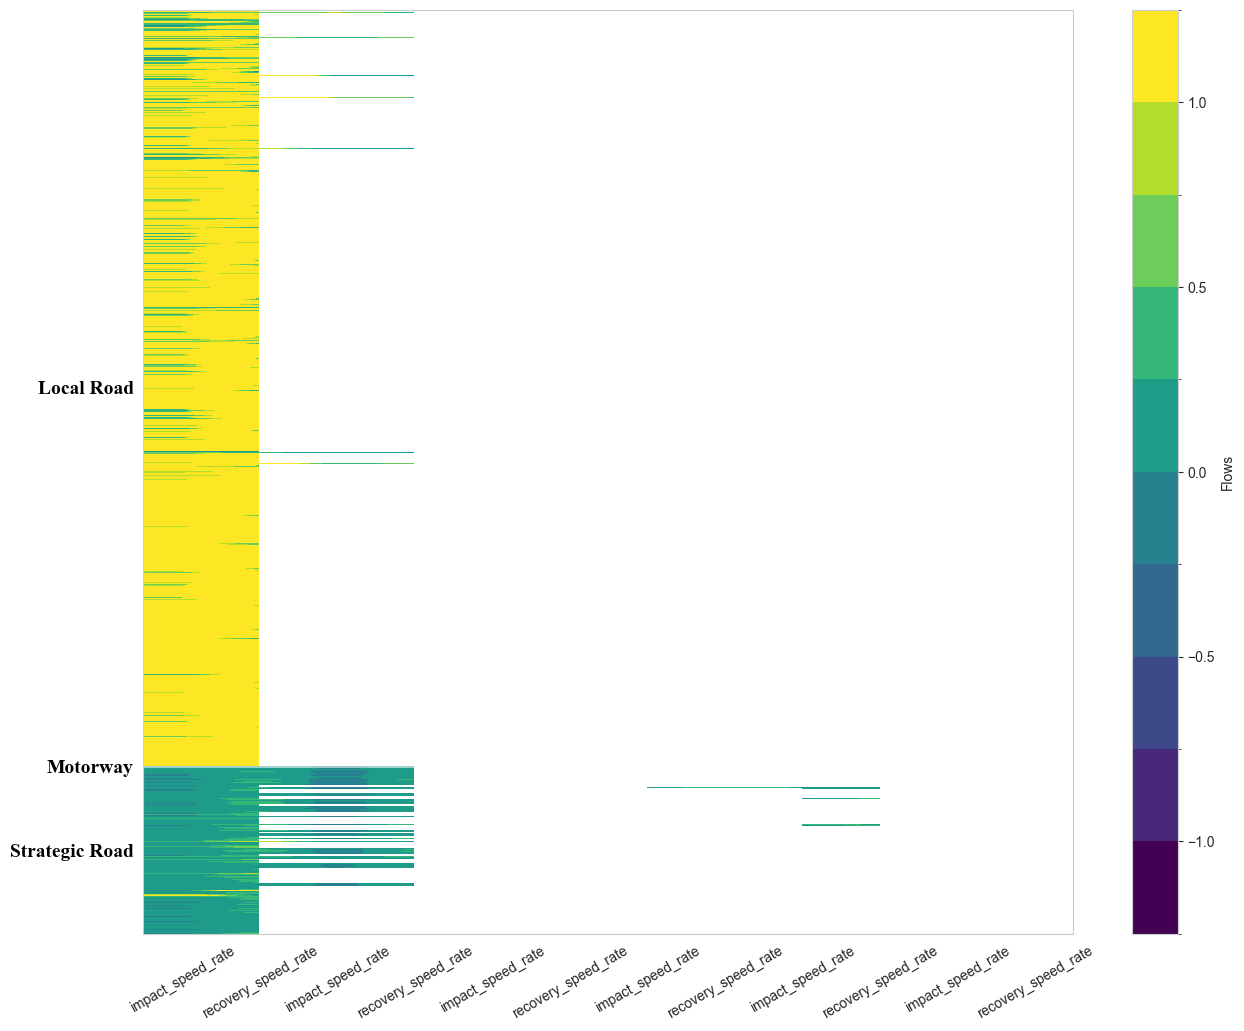

In [72]:
import matplotlib.colors as mcolors

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 12))
boundaries = [-9999, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 9999]  # Define your own levels
cmap = plt.get_cmap("seismic")
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

# Create a heatmap using Seaborn
heatmap = plt.imshow(class_mode_f, cmap='viridis', aspect='auto', origin='upper', norm=norm)

# heatmap = sns.heatmap(class_mode_f, cmap='viridis', ax=ax) 

# # Set title
# ax.set_title("Impact and Recovery Flow by Mode and Classification")

# Set x-axis tick labels and rotation
ax.set_xticks(range(len(class_mode_f.columns)))
ax.set_xticklabels(class_mode_f.columns.get_level_values(1), rotation=30)

# Set y-axis tick labels and classifications
classifications = class_mode_f.index.get_level_values(0).unique()
ax.set_yticks(range(len(classifications)))
ax.set_yticklabels(classifications)

# 获取分类数据的唯一值和数量
unique_classifications, counts = np.unique(class_mode_f.index.get_level_values(0), return_counts=True)
grouped_ticks = np.cumsum(counts) - counts / 2

lines_ticks = np.cumsum(counts)

# 设置左纵轴刻度
font = {'family': 'Times New Roman',
        'color':  'black', 
        'weight': 'bold',
        'size': 14,
        }
ax.set_yticks(grouped_ticks)
ax.set_yticklabels(unique_classifications,fontdict=font)

# 添加纵轴分割线
for tick in lines_ticks[:-1]:
    ax.axhline(tick-0.5, color='white', linewidth=0.4)  # 添加白色分割线，-0.5是为了使线在刻度之间

# 添加颜色条
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Flows')  # 设置颜色条标签

# 移除默认分割线
ax.xaxis.grid(False)
ax.yaxis.grid(False)

plt.show()
fig.savefig(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Output/Print/Impact and Recovery Flow by Mode and Boroughs.png',
    dpi=500, bbox_inches='tight')